<a href="https://colab.research.google.com/github/Ameya6514/MPRNet/blob/main/DCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import math
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

In [ ]:
def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

In [ ]:
def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

In [ ]:
def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

In [ ]:
def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

In [ ]:
def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res

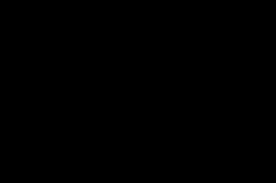

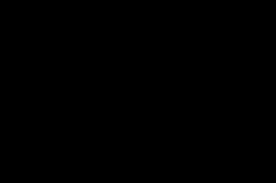

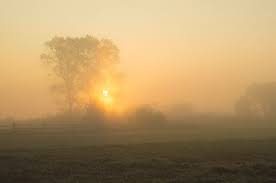

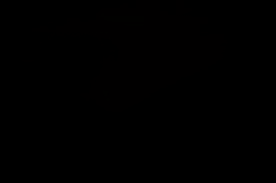

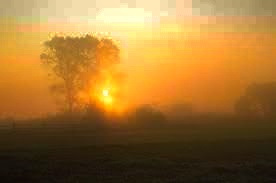

In [ ]:
image_file_path = '/content/drive/MyDrive/Machine Learning/Internship/Image dehazing/download.jpeg'
src = cv2.imread(image_file_path)

# Run the dehazing function
I = src.astype('float64') / 255
dark = DarkChannel(I, 15)
A = AtmLight(I, dark)
te = TransmissionEstimate(I, A, 15)
t = TransmissionRefine(src, te)
J = Recover(I, t, A, 0.1)

# Display the results
from google.colab.patches import cv2_imshow

cv2_imshow(dark)
cv2_imshow(t)
cv2_imshow(src)
cv2_imshow(J)

cv2.imwrite("/content/drive/MyDrive/Machine Learning/Internship/Image dehazing/cleared_img1.jpg", J * 255)
output_img_path = '/content/drive/MyDrive/Machine Learning/Internship/Image dehazing/cleared_img1.jpg'
output_img = cv2.imread(output_img_path)
cv2_imshow(output_img)